<a href="https://colab.research.google.com/github/kgeckin/FIZ_437E/blob/main/knn_group10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install plotly.express

In [2]:
!pip install -U kaleido

In [3]:
pip install psutil

In [4]:
# (a) Import packages and print their versions
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier as SKLearnKNeighborsClassifier
from scipy import stats
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [5]:
# Print package versions
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")


Pandas version: 1.5.3
Numpy version: 1.23.5


In [6]:
# (b) Import custom KNN classifier
class KNeighborsClassifier:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, x):
        labels = []
        for value in x:
            distances = [euclidean_distance(value, X_train) for X_train in self.X_train]
            k_inds = np.argsort(distances)[:self.k]
            classes_k = [self.y_train[i] for i in k_inds]
            mode = stats.mode(classes_k)
            labels.append(mode[0])
        return labels

In [7]:
# (e) Distance functions
def euclidean_distance(x1, x2):
    distance = np.sqrt(np.sum((np.array(x1)-np.array(x2))**2))
    return distance

def minkowski_distance(x1, x2, p=2):
    distance = (np.sum((np.array(x1)-np.array(x2))**p))**(1/p)
    return distance

def manhattan(x1, x2):
    distance = np.sum(np.abs(np.array(x1) - np.array(x2)))
    return distance

In [8]:
# (d) Load data
data = pd.read_csv("htru2.csv")
data.columns = ['pmean', 'pstd', 'pskew', 'pkurt', 'dmean', 'dstd', 'dskew', 'dkur', 'ispulsar']

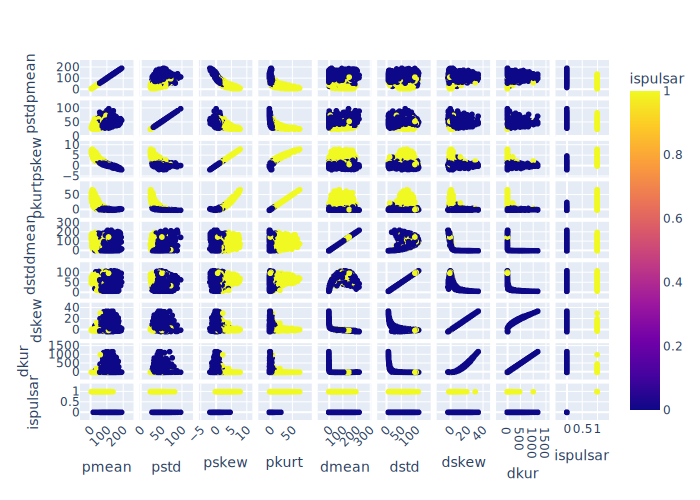

In [28]:
# (c) Plot feature distribution
fig = px.scatter_matrix(
    data,
    color='ispulsar',
    color_discrete_map={0: 'blue', 1: 'orange'}
)

fig.update_layout({"xaxis"+str(i+1): dict(tickangle = -45) for i in range(7)})

fig.show("svg")

In [19]:
# (d) Split data into train and test samples
train_data, test_data = train_test_split(data, test_size=0.0279, random_state=42)  # 5000 samples for training, 500 for testing

In [20]:
# (e) Create KNN models
k_values = [1, 3, 5, 7, 10]
distance_metrics = [euclidean_distance, minkowski_distance, manhattan]

for k in k_values:
    for distance_metric in distance_metrics:
        knn_model = KNeighborsClassifier(k=k)
        knn_model.fit(train_data.iloc[:, :-1].values, train_data['ispulsar'].values)
        predictions = knn_model.predict(test_data.iloc[:, :-1].values)

        # (f) Calculate and discuss accuracy
        correct_predictions = sum(predictions == test_data['ispulsar'])
        wrong_predictions = len(test_data) - correct_predictions
        accuracy = accuracy_score(test_data['ispulsar'], predictions)

        print(f"K={k}, Distance Metric={distance_metric.__name__}")
        print(f"Correct Predictions: {correct_predictions}")
        print(f"Wrong Predictions: {wrong_predictions}")
        print(f"Accuracy: {accuracy:.4f}")
        print()

        # (g) Display confusion matrix and metrics
        cm = confusion_matrix(test_data['ispulsar'], predictions)
        precision = precision_score(test_data['ispulsar'], predictions)
        recall = recall_score(test_data['ispulsar'], predictions)
        f1 = f1_score(test_data['ispulsar'], predictions)

        print("Confusion Matrix:")
        print(cm)
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print()


K=1, Distance Metric=euclidean_distance
Correct Predictions: 478
Wrong Predictions: 22
Accuracy: 0.9560

Confusion Matrix:
[[438  13]
 [  9  40]]
Precision: 0.7547
Recall: 0.8163
F1 Score: 0.7843

K=1, Distance Metric=minkowski_distance
Correct Predictions: 478
Wrong Predictions: 22
Accuracy: 0.9560

Confusion Matrix:
[[438  13]
 [  9  40]]
Precision: 0.7547
Recall: 0.8163
F1 Score: 0.7843

K=1, Distance Metric=manhattan
Correct Predictions: 478
Wrong Predictions: 22
Accuracy: 0.9560

Confusion Matrix:
[[438  13]
 [  9  40]]
Precision: 0.7547
Recall: 0.8163
F1 Score: 0.7843

K=3, Distance Metric=euclidean_distance
Correct Predictions: 487
Wrong Predictions: 13
Accuracy: 0.9740

Confusion Matrix:
[[445   6]
 [  7  42]]
Precision: 0.8750
Recall: 0.8571
F1 Score: 0.8660

K=3, Distance Metric=minkowski_distance
Correct Predictions: 487
Wrong Predictions: 13
Accuracy: 0.9740

Confusion Matrix:
[[445   6]
 [  7  42]]
Precision: 0.8750
Recall: 0.8571
F1 Score: 0.8660

K=3, Distance Metric=man

In [39]:
# (h) Cross-validation procedure
k_values_cv = [1, 2, 3, 5, 10, 15, 20]
fold_accuracies = []

for k_cv in k_values_cv:
    accuracies = []
    for _ in range(5):
        train_fold, test_fold = train_test_split(train_data, test_size=0.2, random_state=42)
        knn_cv = SKLearnKNeighborsClassifier(n_neighbors=k_cv)
        knn_cv.fit(train_fold.iloc[:, :-1].values, train_fold['ispulsar'].values)
        predictions_cv = knn_cv.predict(test_fold.iloc[:, :-1].values)
        accuracy_cv = accuracy_score(test_fold['ispulsar'], predictions_cv)
        accuracies.append(accuracy_cv)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    fold_accuracies.append((k_cv, accuracies, mean_accuracy, std_accuracy))

K-Values vs Accuracy:
K=1, Mean Accuracy: 0.9601, Std Dev: 0.0000
K=2, Mean Accuracy: 0.9670, Std Dev: 0.0000
K=3, Mean Accuracy: 0.9690, Std Dev: 0.0000
K=5, Mean Accuracy: 0.9690, Std Dev: 0.0000
K=10, Mean Accuracy: 0.9730, Std Dev: 0.0000
K=15, Mean Accuracy: 0.9718, Std Dev: 0.0000
K=20, Mean Accuracy: 0.9710, Std Dev: 0.0000


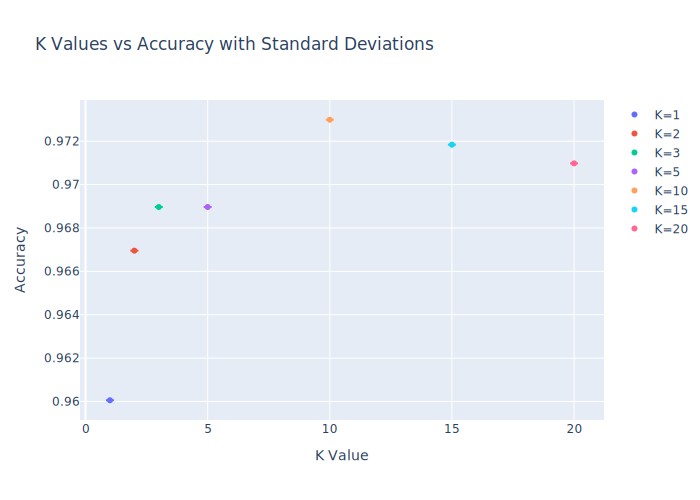

In [42]:
# Print results
print("K-Values vs Accuracy:")
for k_cv, _, mean_acc, std_acc in fold_accuracies:
    print(f"K={k_cv}, Mean Accuracy: {mean_acc:.4f}, Std Dev: {std_acc:.4f}")

# (h) Plot k values vs accuracy graph
fig_cv = go.Figure()

for k_cv, _, mean_acc, std_acc in fold_accuracies:
    fig_cv.add_trace(go.Scatter(x=[k_cv], y=[mean_acc],
                               mode='markers',
                               error_y=dict(type='data', array=[std_acc], visible=True),
                               name=f'K={k_cv}'))

fig_cv.update_layout(title='K Values vs Accuracy with Standard Deviations',
                     xaxis_title='K Value',
                     yaxis_title='Accuracy',
                     showlegend=True)

fig_cv.show("svg")

# Based on the analysis, choose the k value with the highest mean accuracy and reasonable standard deviation.